## Mapping FREE Agribalyse_database (raw conventional agricultural products and organic products (at the farm gate)) wh user selected LCIA

AGRIBALYSE® data is freely available:
https://doc.agribalyse.fr/documentation-en/agribalyse-data/data-access

we use ' simplified version, accessible to everyone : '
- two spreadsheets for raw conventional agricultural products and organic products (at the farm gate)
- a spreadsheet for feed (available soon),
- a spreadsheet for ready-to-eat food products.


in this notebook, we extract mapping for the "conventional or organic products (at the farm gate)", note that unlike "ready-to-eat" product where LCIA scores for each life cycle (LC) stage is provided, here, only a single farm-gate LCIA score provided.

<b>when downloading farm-gate data,  choose the link in the box (binary type), link from bullet point is broken [as of April 12 2023] </b>


LCIA implemented as shown in AGRIBALYSE® spreadsheet: 
- Score unique EF 3.1 
- EF Method 3.0 - implémentation SimaPro (adapted) V1.00 / EF3.0 normalization and weighting set
- ref on the LCIA EF3.0: 
    - https://link.springer.com/article/10.1007/s11367-019-01604-y/tables/1
    - https://link.springer.com/article/10.1007/s11367-019-01604-y/tables/3

In [1]:
# dataframe tools
import pandas as pd
import numpy as np
from tqdm import tqdm

# metrics functions
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# custom package
from caml import config
from caml.similarity import MLModel

# interactive input tools
import ipywidgets as widgets
from ipywidgets import VBox
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../Module')  #a level up & then down to Module folder
from lci_ml_mod import *

#### below example using organic product

In [3]:
agri_df = pd.read_excel("data/AGRIBALYSE3.1_partie agriculture_bio_vf.xlsx", sheet_name =  "AGB_agri_bio", header = [1,2])
#agri_df.head()

In [4]:
#agri_df.columns  # LCIA score: except first 3 cols,also excl col 4 end-indicator -mPt / kg de produit
all_lcia = agri_df.columns[4:]
#all_lcia
#all_lcia[0]

In [5]:
# converting French to English
IC_name = ["Climate_change", "Ozone_depletion", "Ionizing_radiation", "Photochemical_ozone_formation",
          "Particulate_matter", "Human_toxicity_non-cancer", "Human_toxicity_cancer", "Acidification",
          "Eutrophication_freshwater", "Eutrophication_marine", "Eutrophication_terrestrial", 
          "Ecotoxicity_freshwater", "Land_use", "Water_use", "Resource_use_fossils", "Resource_use_minerals-and-metals"]

In [6]:
lcia_unit = [all_lcia[i][1] for i in list(range(0, len(all_lcia)))] 
#lcia_unit

In [7]:
# store unit for each impact category, will be used for table headers / plotting label
dict_IC_unit = {IC_name[i]: lcia_unit[i] for i in range(len(lcia_unit))}
dict_IC_unit

{'Climate_change': 'kg CO2 eq/kg',
 'Ozone_depletion': 'kg CFC11 eq/kg',
 'Ionizing_radiation': 'kBq U-235 eq/kg',
 'Photochemical_ozone_formation': 'kg NMVOC eq/kg',
 'Particulate_matter': 'disease inc./kg',
 'Human_toxicity_non-cancer': 'CTUh/kg',
 'Human_toxicity_cancer': 'CTUh/kg',
 'Acidification': 'mol H+ eq/kg',
 'Eutrophication_freshwater': 'kg P eq/kg',
 'Eutrophication_marine': 'kg N eq/kg',
 'Eutrophication_terrestrial': 'mol N eq/kg',
 'Ecotoxicity_freshwater': 'CTUe/kg',
 'Land_use': 'Pt/kg',
 'Water_use': 'm3 depriv./kg',
 'Resource_use_fossils': 'MJ/kg',
 'Resource_use_minerals-and-metals': 'kg Sb eq/kg'}

### Extract all LCI that will be mapped against your input product

In [8]:
agri_list = agri_df[("Unnamed: 1_level_0","LCI Name")].values  #two headers here, using all lines
print(len(agri_list))

224


### User input impact category - directly define in the list, add in as many IC as you like

In [9]:
sel_ic_multiple = ["Water_use", "Climate_change"] #, "Eutrophication_freshwater"

#### Extract all LCIA scores according to user selected impact category, this output will be used in follow-up datatable/plotting

In [10]:
#need to add in another parameter all_lcia as its original col_name to screen DF
LC_lcia = agribs_farm_gate_extract_lcia(all_lcia, dict_IC_unit, sel_ic_multiple, agri_df)

### start ML mapping user input product to the database

In [11]:
product_list = [
    "cow milk",
    "peach",
    "egg"
]

In [12]:
model = MLModel(config.model_name)
cosine_scores = model.compute_similarity_scores(product_list, agri_list)

### Only see LCI mapped with highest cosine_score, w/h total LCIA score (no seperate LC stage for farm-gate LCI)

In [13]:
ss = map_agribs_farm_gate_single_lci_wh_lcia(cosine_scores,dict_IC_unit, sel_ic_multiple, product_list, agri_list , LC_lcia)
ss[0]

,your product,AGRIBALYSE_mapped,m3 depriv./kg,cosine_score
0,cow milk,"Cow milk, organic, system number 3, at farm gate/FR U",0.115587,0.653
1,peach,"Peach, organic, national average, at orchard/FR U",21.307540,0.555
2,egg,"Egg, organic, at farm gate/FR U",8.772587,0.570


In [14]:
ss[1]

,your product,AGRIBALYSE_mapped,kg CO2 eq/kg,cosine_score
0,cow milk,"Cow milk, organic, system number 3, at farm gate/FR U",0.800551,0.653
1,peach,"Peach, organic, national average, at orchard/FR U",0.218376,0.555
2,egg,"Egg, organic, at farm gate/FR U",1.726961,0.570


### If you wanna see first N [here suggest only up to 3 as relatively short inventory list] closest mapped product,  w/h all life cycle stage LCIA impact scores

In [15]:
final_result = map_agribs_farm_gate_multiple_lci_wh_lcia(1, cosine_scores,dict_IC_unit, sel_ic_multiple, product_list, agri_list, LC_lcia)

In [16]:
final_result[0]

,,,AGRIBALYSE_mapped,ML_score,farm-gate_total
your_product,,,,,
cow milk,Water_use,1,"Cow milk, organic, system number 3, at farm gate/FR U",0.653166,0.115587
peach,Water_use,1,"Peach, organic, national average, at orchard/FR U",0.555247,21.307540
egg,Water_use,1,"Egg, organic, at farm gate/FR U",0.570275,8.772587


#### Let's plot out the farm-gate LCIA scores for the multiple IC  for a selected product 

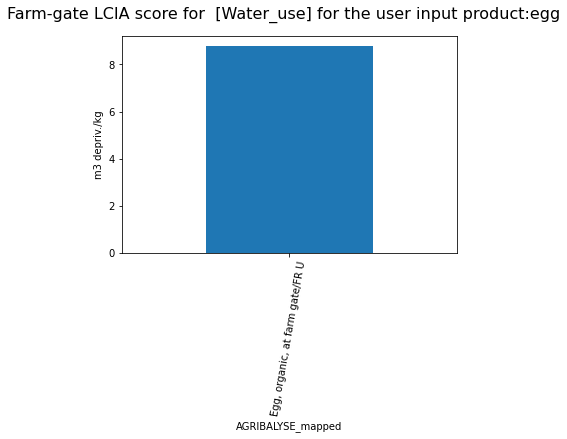

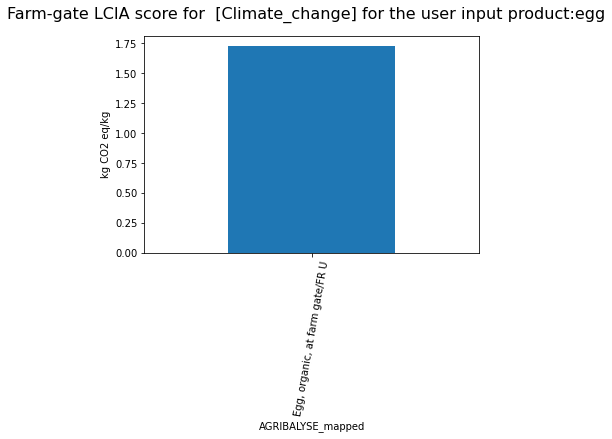

In [17]:
# or directly define product name here:
name = 'egg'

for i, sel_ic in zip( range(len(sel_ic_multiple)), sel_ic_multiple):
    plot_df = final_result[i].loc[name,:]
    plot_df.plot.bar(legend = None, x="AGRIBALYSE_mapped", y=["farm-gate_total"], 
                     ylabel = dict_IC_unit.get(sel_ic), figsize=(6,4) )
    plt.xticks(rotation = 80)
    plt.suptitle(("Farm-gate LCIA score for " + " ["+ sel_ic + "] " + "for the user input product:" + name ), fontsize=16)
    #plt.title("x-axis shows ML scores highest to lowest from left to right", fontsize=12)
    plt.show()

### Compare LCIA from product_list in same plot

In [18]:
df_comb = pd.DataFrame()
for i in range(len(final_result)):
    data = final_result[i]
    df_comb=df_comb.append(data,ignore_index=False)
df_comb = df_comb.T
df_comb

/var/folders/9p/gvkl7h6551515cs56m93ldgr0000gn/T/ipykernel_3919/3631835052.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comb=df_comb.append(data,ignore_index=False)
/var/folders/9p/gvkl7h6551515cs56m93ldgr0000gn/T/ipykernel_3919/3631835052.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comb=df_comb.append(data,ignore_index=False)


your_product,cow milk,peach,egg,cow milk,peach,egg
,Water_use,Water_use,Water_use,Climate_change,Climate_change,Climate_change
,1,1,1,1,1,1
AGRIBALYSE_mapped,"Cow milk, organic, system number 3, at farm gate/FR U","Peach, organic, national average, at orchard/FR U","Egg, organic, at farm gate/FR U","Cow milk, organic, system number 3, at farm gate/FR U","Peach, organic, national average, at orchard/FR U","Egg, organic, at farm gate/FR U"
ML_score,0.653166,0.555247,0.570275,0.653166,0.555247,0.570275
farm-gate_total,0.115587,21.30754,8.772587,0.800551,0.218376,1.726961


In [19]:
comp_name = product_list # or select only several from the list ['cow milk' , 'egg']

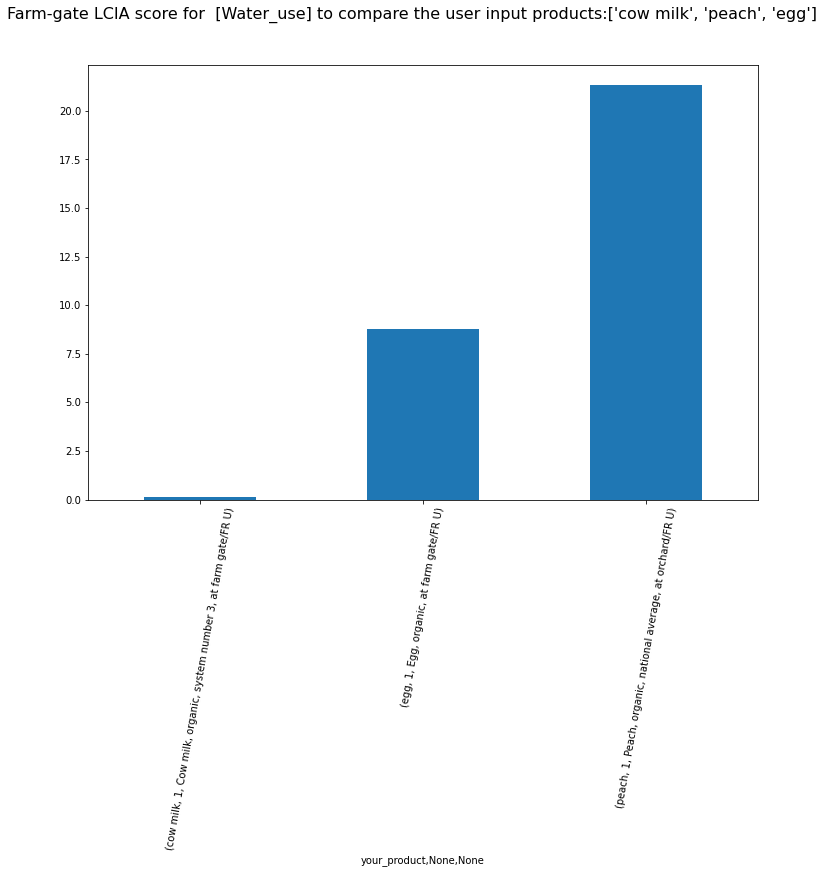

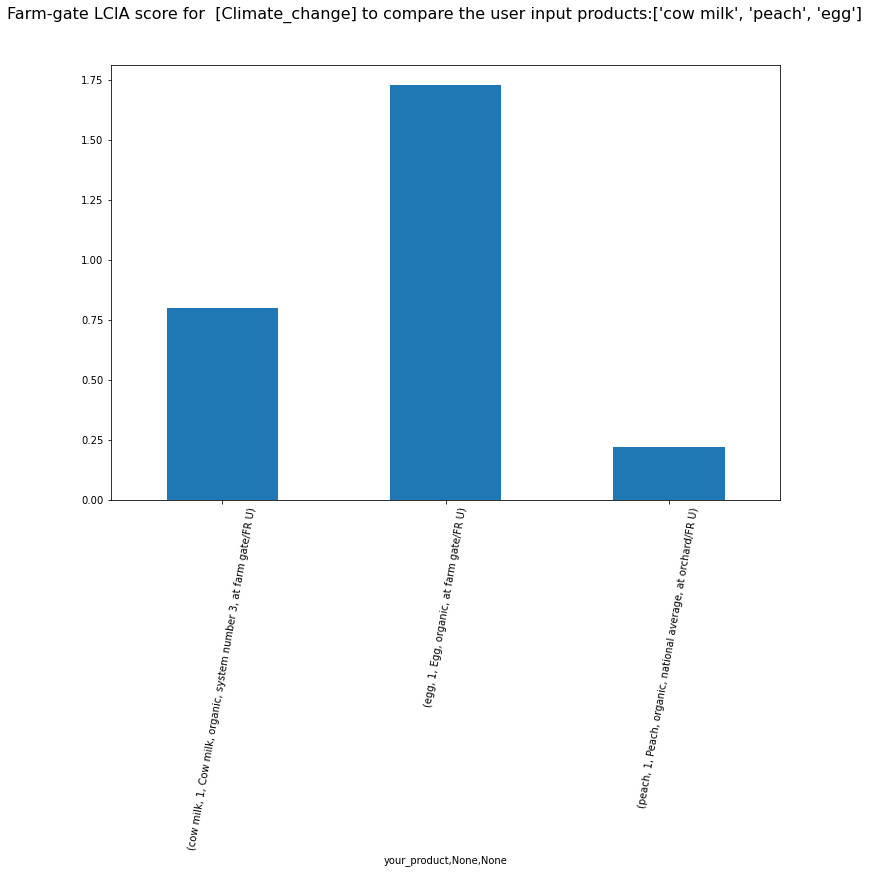

In [20]:
for sel_ic in sel_ic_multiple:
    plot_df = df_comb.loc[:, ( comp_name,  sel_ic)]
    plot_df = plot_df.T.unstack(level=1)
    #plot_df.index = plot_df[("AGRIBALYSE_mapped", sel_ic)].values
    plot_df = plot_df.set_index(plot_df[("AGRIBALYSE_mapped", sel_ic)].values, append=True) 
    plot_df.plot.bar(legend=None, y=["farm-gate_total"], figsize=(12,8) )
    plt.xticks(rotation = 80)
    plt.suptitle(("Farm-gate LCIA score for " + " ["+ sel_ic + "] " + "to compare the user input products:" +  str(comp_name) ), fontsize=16)
    plt.show()